# 资产风险平价和因子风险平价

In [286]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm
from sklearn.decomposition import PCA

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *
from backtest import *

In [346]:
# 回测参数
date_range = [datetime(2015,1,1), datetime(2021,12,31)]
frequency = 22 
look_back = 252*5

## 1. 载入资产和因子数据

In [291]:
# 读入资产数据
asset_data_raw = getAssetData().fillna(method='ffill')

# 读入因子数据
factor_data_raw = getFactorData().reindex(asset_data_raw.index).fillna(method='ffill')

## 2. 资产风险平价

In [354]:
class AssetRiskParityStrategy(Strategy):
    def run(self, id_date, asset_data):
        w0 = [1/asset_data.shape[1]] * asset_data.shape[1]
        asset_cov = np.matrix(asset_data.pct_change().cov()*252)

        # opt
        cons = [] 
        cons.append({'type': 'eq', 'fun': lambda w: sum(w)-1})
        bounds = tuple([(0,1)] * asset_data.shape[1])
        res =  minimize(self.riskLoss, w0, constraints=cons, args=(asset_cov), bounds=bounds,  method='SLSQP')
        if res.success == False:
            print(res)
        #print(res.x)

        asset_weights = minimize(self.riskLoss, w0, constraints=cons, args=(asset_cov), bounds=bounds,  method='SLSQP').x
        # sys.exit(1)
        return pd.Series(asset_weights, index=asset_data.columns).T

    def riskLoss(self, w, asset_cov):
        w = np.matrix(w).T
        # print(self.getAssetRisk(w, asset_cov).squeeze().round(3), self.getProtfolioRisk(w, asset_cov))
        return ((self.getAssetRisk(w, asset_cov) - self.getProtfolioRisk(w, asset_cov)/w.shape[0]) ** 2).sum()

    def getProtfolioRisk(self, w, asset_cov):
        return np.sqrt(w.T @ asset_cov @ w)[0,0]

    def getAssetRisk(self, w, asset_cov):
        return np.array(w) * (np.array(asset_cov @ w)) / self.getProtfolioRisk(w, asset_cov)

In [355]:
asset_risk_party_backtest = BacktestManager(
        AssetRiskParityStrategy(), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = frequency, 
        look_back = look_back, 
    )
asset_risk_party_backtest.run()

100%|█████████████████████████████████████████████████████████████████████████████| 1705/1705 [00:15<00:00, 109.28it/s]


<AxesSubplot:>

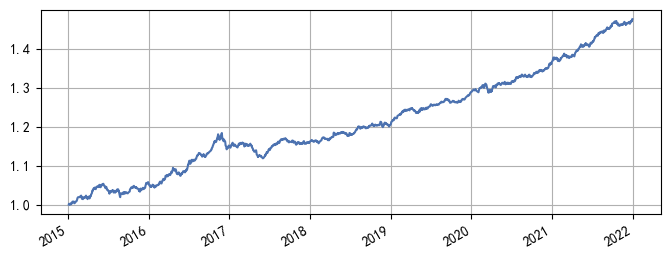

In [356]:
asset_risk_party_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

In [317]:
def getFactorExposure(returns, factors):
    '''
    使用多元回归计算因子暴露
    输入：资产净值和因子值
    输出：资产在因子上的暴露（β）
    '''
    assert returns.shape[0] == factors.shape[0]
    return sm.OLS(returns, factors.astype(float)).fit().params.iloc[1:]

def getFatorExposureFrame(asset_returns, factors, norm=False):
    '''
    敞口矩阵
    norm：是否归一化
    '''
    #asset_returns = (asset_returns - asset_returns.mean()) / asset_returns.std()
    #factors = (factors - factors.mean()) / factors.std()
    # 因子数据添加常数项
    factors = sm.add_constant(factors)
    exposure_frame = pd.DataFrame(columns=factors.columns[1:])
    for asset in asset_returns.columns:
        exposure_frame.loc[asset] = getFactorExposure(asset_returns[asset], factors) 
    if norm:
        exposure_frame = (exposure_frame - exposure_frame.mean()) / exposure_frame.std()
    return exposure_frame

## 3. 因子风险平价

In [347]:
class FactorRiskParityStrategy(Strategy):
    def __init__(self, use_pca_factor=False, factor_data=None, pca_n_components=4):
        self._use_pca_factor = use_pca_factor
        self._factor_data = factor_data
        self._pca_n_components = pca_n_components

        if not use_pca_factor:
            self._factor_risk = pd.DataFrame(columns=factor_data.columns)
        else:
            self._factor_risk = pd.DataFrame(columns=['factor_{}'.format(i) for i in range(self._pca_n_components)])

    def getPcaFactorReturns(self, asset_data):
        asset_data = asset_data.dropna()
        asset_return = asset_data.pct_change().fillna(0)

        pca=PCA(n_components=self._pca_n_components)  
        asset_return_pca = pca.fit_transform(asset_return)
        asset_return_pca = pd.DataFrame(asset_return_pca)

        asset_return_pca.index = asset_data.index
        asset_return_pca.columns = ['factor_{}'.format(i) for i in range(asset_return_pca.shape[1])]

        return asset_return_pca

    def getProtfolioRisk(self, w, asset_cov):
        return np.sqrt(w.T @ asset_cov @ w)[0,0]

    def riskLoss(self, w, asset_cov, A_T, A_pinv):
        w = np.matrix(w).T
        # print(self.getFactorRisk(w, asset_cov, A_T, A_pinv).squeeze().round(5), self.getProtfolioRisk(w, asset_cov))
        res =  ((self.getFactorRisk(w, asset_cov, A_T, A_pinv) - self.getProtfolioRisk(w, asset_cov)/A_T.shape[0]) ** 2).sum()
        return res*1000000

    def getProtfolioRisk(self, w, asset_cov):
        #print(w)
        #print(asset_cov)
        return np.sqrt(w.T @ asset_cov @ w)[0,0] 

    def getFactorRisk(self, w, asset_cov, A_T, A_pinv):
        #print(w)
        #print(self.getProtfolioRisk(w, asset_cov))
        return np.array(A_T @ w) * np.array(A_pinv @ asset_cov @ w) / self.getProtfolioRisk(w, asset_cov) 

    def run(self, id_date, asset_data):
        if self._use_pca_factor:
            factor_returns = self.getPcaFactorReturns(asset_data)
        else:
            factor_returns = self._factor_data.reindex(asset_data.index).dropna().pct_change().fillna(0)
        asset_returns = asset_data.pct_change().reindex(factor_returns.index).fillna(0)

        w0 = [1/asset_data.shape[1]] * asset_data.shape[1]
        asset_cov = np.matrix(asset_data.pct_change().cov())
        #print(asset_returns.head())
        #print(factor_returns.head())
        A = getFatorExposureFrame(asset_returns, factor_returns)
        #print(A)
        A_T = np.matrix(A).T
        A_pinv = np.linalg.pinv(np.matrix(A))

        # opt
        cons = [] 
        cons.append({'type': 'eq', 'fun': lambda w: sum(w)-1})
        #cons.append({'type': 'ineq', 'fun': lambda x: -sum(x) + 1})
        #cons.append({'type': 'ineq', 'fun': lambda x: sum(x) - 1})
        # bounds = tuple([(-1,1)] * asset_data.shape[1])
        bounds = tuple([(0,1)] * asset_data.shape[1])
        options={'disp':False, 'maxiter':10000, 'ftol':1e-30}
        
        res = minimize(self.riskLoss, w0, constraints=cons, args=(asset_cov, A_T, A_pinv), bounds=bounds,  method='SLSQP', options=options)
        print(res.success)
        print(res.x)
        if res.success == False:
            print(id_date)
            
        asset_weights = res.x

        self._factor_risk.loc[id_date] = np.array(self.getFactorRisk(asset_weights, asset_cov, A_T, A_pinv)).squeeze()
        # print(self.getFactorRisk(asset_weights, asset_cov, A_T, A_pinv))
        # sys.exit(1)

        return pd.Series(asset_weights, index=asset_data.columns).T


        

        
            

In [348]:
factor_risk_party_backtest_pca = BacktestManager(
        FactorRiskParityStrategy(use_pca_factor=True), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = frequency, 
        look_back = look_back, 
    )
factor_risk_party_backtest_pca.run()

  1%|▊                                                                              | 18/1705 [00:00<00:16, 100.23it/s]

False
[2.12825169e-16 6.27443901e-16 6.00437748e-02 8.27003539e-01
 9.79640006e-02 1.10173984e-02 3.97128708e-03 0.00000000e+00]
2015-01-05 00:00:00


  3%|██                                                                              | 45/1705 [00:00<00:21, 78.57it/s]

False
[0.         0.         0.05764323 0.82660802 0.10058832 0.0115914
 0.00356903 0.        ]
2015-02-04 00:00:00
False
[0.00000000e+00 0.00000000e+00 5.78522751e-02 8.23964878e-01
 1.03876866e-01 1.16438755e-02 2.66210457e-03 7.99451443e-17]
2015-03-13 00:00:00


  5%|████▏                                                                           | 89/1705 [00:01<00:16, 96.69it/s]

False
[2.00909577e-16 0.00000000e+00 4.45959053e-02 8.33534928e-01
 1.09087422e-01 8.75965066e-03 4.02209394e-03 0.00000000e+00]
2015-04-15 00:00:00
False
[1.75516622e-17 0.00000000e+00 4.24537376e-02 8.30236689e-01
 1.11622662e-01 1.38579994e-02 1.82891293e-03 1.09188830e-16]
2015-05-18 00:00:00


  8%|██████▏                                                                        | 133/1705 [00:01<00:16, 97.48it/s]

False
[4.39014752e-21 3.82337154e-16 3.99620902e-02 8.48438579e-01
 8.93566530e-02 1.83274722e-02 3.91520558e-03 3.36690725e-20]
2015-06-17 00:00:00
True
[1.37855445e-16 9.00243733e-26 3.46543460e-02 8.52639671e-01
 1.69130035e-02 1.01034464e-02 1.05502233e-02 7.51393096e-02]


 10%|███████▌                                                                      | 165/1705 [00:01<00:14, 107.24it/s]

True
[4.12845132e-17 1.25111684e-16 2.99954660e-02 8.97510524e-01
 2.45256671e-02 1.67598131e-02 3.12085294e-02 7.30052346e-18]


 11%|████████▋                                                                      | 187/1705 [00:01<00:16, 90.05it/s]

True
[1.11449622e-03 4.45901165e-17 2.90396284e-02 8.98655087e-01
 2.44646787e-02 1.71054973e-02 2.96206125e-02 6.88964344e-20]


 13%|█████████▉                                                                     | 214/1705 [00:02<00:16, 91.49it/s]

True
[1.71918029e-03 5.67577686e-18 2.60174364e-02 9.00200604e-01
 2.54459313e-02 1.71611329e-02 2.94557145e-02 0.00000000e+00]


 13%|██████████▍                                                                    | 225/1705 [00:02<00:20, 73.81it/s]

True
[1.74287670e-03 3.12625085e-18 2.30957955e-02 8.62228926e-01
 1.46739943e-02 1.56631637e-02 8.56302347e-03 7.40322198e-02]


 15%|████████████                                                                   | 259/1705 [00:02<00:15, 91.86it/s]

True
[2.80142084e-02 0.00000000e+00 5.14159723e-02 9.20569819e-01
 0.00000000e+00 1.97341691e-16 4.53678727e-23 3.21521760e-16]


 16%|████████████▌                                                                  | 270/1705 [00:03<00:17, 82.00it/s]

True
[5.22140227e-03 2.41103475e-22 4.48748136e-02 8.79408906e-01
 2.33513935e-02 2.06448580e-02 2.64986264e-02 3.72809848e-17]


 18%|██████████████                                                                 | 304/1705 [00:03<00:14, 98.43it/s]

True
[5.92464568e-03 4.06866531e-17 4.99320180e-02 8.73122357e-01
 2.49725432e-02 1.94692091e-02 2.65792270e-02 1.54570712e-16]


 19%|██████████████▋                                                                | 316/1705 [00:03<00:15, 91.81it/s]

True
[1.14286104e-16 2.17023474e-02 5.35141879e-02 9.24783465e-01
 3.47301806e-17 4.49410742e-26 0.00000000e+00 6.77707502e-27]


 21%|████████████████▏                                                              | 350/1705 [00:03<00:13, 98.33it/s]

False
[9.97804122e-19 2.21479760e-02 5.86872580e-02 9.19164766e-01
 7.05540668e-17 8.76469015e-17 7.36405306e-17 1.36981705e-16]
2016-05-12 00:00:00
True
[0.         0.0047839  0.05014495 0.86190359 0.03378041 0.0154762
 0.03391095 0.        ]


 23%|██████████████████                                                            | 394/1705 [00:04<00:11, 111.15it/s]

True
[0.00000000e+00 4.54535787e-03 4.60405634e-02 8.65747063e-01
 3.50935913e-02 1.41341976e-02 3.44392267e-02 4.69723374e-16]


 24%|██████████████████▊                                                            | 407/1705 [00:04<00:13, 93.70it/s]

True
[1.19693507e-16 2.18610106e-02 5.64233894e-02 9.21715600e-01
 1.83014116e-17 8.36676612e-18 7.26331616e-20 5.52181311e-17]


 25%|███████████████████▉                                                           | 430/1705 [00:04<00:15, 83.12it/s]

True
[7.92416268e-21 2.17084610e-02 5.41585430e-02 9.24132996e-01
 3.89979042e-21 2.30870150e-16 1.85139515e-16 1.71214939e-16]


 27%|█████████████████████▎                                                         | 459/1705 [00:05<00:12, 96.52it/s]

False
[0.         0.00402642 0.04340472 0.86573185 0.03565943 0.01353676
 0.03764082 0.        ]
2016-10-26 00:00:00


 28%|█████████████████████▊                                                         | 471/1705 [00:05<00:14, 85.09it/s]

True
[1.68383013e-18 2.17435358e-02 5.27348942e-02 9.25521570e-01
 7.69053964e-18 6.29937921e-23 1.87702889e-16 3.54451363e-17]


 29%|██████████████████████▉                                                        | 494/1705 [00:05<00:15, 77.82it/s]

False
[5.78468532e-24 4.42249904e-03 3.83851558e-02 8.58101800e-01
 4.15064838e-02 1.19096520e-02 4.56744095e-02 4.15970101e-18]
2016-12-27 00:00:00


 31%|████████████████████████                                                      | 527/1705 [00:05<00:11, 106.10it/s]

True
[0.         0.0050289  0.04110988 0.85083891 0.0451535  0.01345891
 0.0444099  0.        ]


 32%|████████████████████████▉                                                      | 539/1705 [00:06<00:15, 73.75it/s]

True
[6.69962596e-17 5.40274808e-03 4.33048287e-02 8.47335830e-01
 4.58187783e-02 1.34033173e-02 4.47344975e-02 6.11747705e-25]


 33%|██████████████████████████▎                                                    | 567/1705 [00:06<00:12, 87.57it/s]

True
[1.03676972e-16 4.53297254e-03 4.26819194e-02 8.49109014e-01
 4.50634536e-02 1.44981621e-02 4.41144783e-02 5.16933310e-16]


 35%|███████████████████████████▍                                                   | 591/1705 [00:06<00:15, 71.05it/s]

True
[3.71974202e-17 3.93462749e-03 3.94152344e-02 8.52126848e-01
 4.49133322e-02 1.52921979e-02 4.43177602e-02 5.43330353e-18]


 36%|████████████████████████████▌                                                  | 617/1705 [00:07<00:14, 75.39it/s]

True
[7.34694656e-17 3.83108726e-03 3.62827335e-02 8.54349241e-01
 4.63911194e-02 1.54716614e-02 4.36741573e-02 5.47069131e-19]
False
[0.         0.00372771 0.03537974 0.85600143 0.04610282 0.0150107
 0.04377761 0.        ]
2017-07-14 00:00:00


 38%|██████████████████████████████                                                 | 648/1705 [00:07<00:14, 75.14it/s]

True
[2.81662211e-16 4.10273855e-03 2.90052277e-02 8.64315421e-01
 4.46909991e-02 1.56559291e-02 4.22296845e-02 1.10049253e-19]


 40%|███████████████████████████████▍                                               | 679/1705 [00:07<00:11, 93.24it/s]

True
[1.51644156e-17 3.34597387e-03 2.99238312e-02 8.64025394e-01
 4.33325491e-02 1.65731157e-02 4.27991359e-02 2.72243703e-17]
True
[0.00000000e+00 2.68157692e-03 2.60602313e-02 8.68672321e-01
 4.21978790e-02 1.76406241e-02 4.27473680e-02 2.02743444e-16]


 43%|█████████████████████████████████▎                                            | 727/1705 [00:08<00:09, 100.81it/s]

True
[4.34703657e-17 2.44255019e-03 2.63496955e-02 8.67364624e-01
 4.27020586e-02 1.96721018e-02 4.14689704e-02 4.11281037e-17]
True
[4.73240736e-17 2.43028143e-03 2.55531844e-02 8.69199714e-01
 4.02889116e-02 2.03712582e-02 4.21566506e-02 0.00000000e+00]


 45%|███████████████████████████████████▋                                           | 771/1705 [00:08<00:09, 98.97it/s]

True
[2.86974110e-17 2.18350124e-03 2.66645178e-02 8.68232567e-01
 3.97883992e-02 2.07177827e-02 4.24132320e-02 1.54229286e-20]
True
[2.64888642e-26 2.07283706e-03 2.55999226e-02 8.68861275e-01
 4.00881075e-02 2.06515636e-02 4.27262945e-02 1.04850554e-16]


 48%|█████████████████████████████████████▎                                        | 815/1705 [00:09<00:08, 103.35it/s]

True
[0.         0.00203585 0.02459177 0.87025869 0.03936185 0.02053946
 0.04321238 0.        ]
False
[0.00000000e+00 1.92682301e-03 1.51733360e-02 8.80777867e-01
 3.93049791e-02 1.93406924e-02 4.34763026e-02 8.56053732e-17]
2018-05-09 00:00:00


 50%|███████████████████████████████████████▏                                       | 845/1705 [00:09<00:08, 96.02it/s]

True
[6.38536834e-17 2.15937056e-03 1.61865836e-02 8.79216906e-01
 3.90608307e-02 1.99961207e-02 4.33801885e-02 5.31818796e-18]


 51%|████████████████████████████████████████                                      | 877/1705 [00:09<00:07, 107.24it/s]

True
[7.23088752e-17 2.16845538e-03 1.34612453e-02 8.81977431e-01
 3.92047805e-02 2.06528529e-02 4.25352349e-02 5.14869400e-22]


 53%|█████████████████████████████████████████▋                                     | 900/1705 [00:10<00:10, 78.64it/s]

True
[6.03241607e-18 3.46853836e-03 1.69467214e-02 8.77184150e-01
 4.03713295e-02 2.00099236e-02 4.20193368e-02 4.28024674e-18]


 53%|██████████████████████████████████████████▏                                    | 910/1705 [00:10<00:10, 73.87it/s]

True
[6.75990193e-18 4.60401396e-03 2.21019747e-02 8.73400801e-01
 3.75099586e-02 2.12013820e-02 4.11818702e-02 3.26387291e-17]


 55%|███████████████████████████████████████████▋                                   | 943/1705 [00:10<00:07, 96.01it/s]

True
[5.98065880e-17 5.80293054e-03 2.37490632e-02 8.71414977e-01
 3.95801568e-02 2.01433892e-02 3.93094830e-02 5.42307686e-18]
True
[9.47290218e-17 6.58881112e-03 2.37151716e-02 8.69591008e-01
 4.07902050e-02 1.95209202e-02 3.97938843e-02 1.98568062e-18]


 58%|█████████████████████████████████████████████▏                                | 989/1705 [00:11<00:06, 106.25it/s]

True
[2.01470297e-20 6.44127604e-03 2.20059611e-02 8.72746970e-01
 3.89121072e-02 1.99632942e-02 3.99303914e-02 2.32106564e-17]


 59%|██████████████████████████████████████████████▎                               | 1013/1705 [00:11<00:08, 85.17it/s]

True
[1.60269814e-18 5.66857788e-03 2.62456982e-02 8.70888259e-01
 3.81688712e-02 2.04219269e-02 3.86066664e-02 2.96450956e-18]
True
[4.99590188e-17 5.92126598e-03 2.78818086e-02 8.68896940e-01
 3.88175687e-02 1.97370697e-02 3.87453468e-02 4.05537359e-27]


 62%|████████████████████████████████████████████████▎                             | 1057/1705 [00:11<00:07, 87.57it/s]

True
[4.18112245e-17 6.41546118e-03 2.92632551e-02 8.67401767e-01
 3.86040799e-02 1.93251640e-02 3.89902731e-02 4.44384684e-18]
True
[2.48150227e-17 7.41008823e-03 2.67043581e-02 8.72279683e-01
 3.84050763e-02 1.71949517e-02 3.80058429e-02 3.62870464e-26]


 65%|█████████████████████████████████████████████████▋                           | 1100/1705 [00:12<00:05, 106.42it/s]

True
[4.47167843e-18 7.26960019e-03 2.51458271e-02 8.75100724e-01
 3.76288343e-02 1.70358792e-02 3.78191351e-02 1.10917970e-17]
True
[1.36508527e-16 6.92763137e-03 3.26348400e-02 8.68499005e-01
 3.82467741e-02 1.67908130e-02 3.69009369e-02 3.23922640e-18]


 67%|███████████████████████████████████████████████████▋                         | 1144/1705 [00:12<00:04, 116.68it/s]

True
[0.         0.00712953 0.03359729 0.86728684 0.03858992 0.0166475
 0.03674892 0.        ]
True
[0.00000000e+00 7.15212089e-03 3.49181783e-02 8.65987137e-01
 3.84062056e-02 1.68199833e-02 3.67163753e-02 6.74266327e-25]


 69%|█████████████████████████████████████████████████████▍                       | 1184/1705 [00:13<00:05, 101.74it/s]

True
[3.01546317e-17 7.52490906e-03 3.51399523e-02 8.66306203e-01
 3.80101948e-02 1.62329854e-02 3.67857557e-02 1.33641618e-17]


 70%|██████████████████████████████████████████████████████▋                       | 1196/1705 [00:13<00:05, 94.10it/s]

True
[1.70288576e-16 7.45163337e-03 3.48077900e-02 8.67169132e-01
 3.70705083e-02 1.67972161e-02 3.67037199e-02 3.49724595e-20]


 72%|███████████████████████████████████████████████████████▌                     | 1231/1705 [00:13<00:04, 109.69it/s]

True
[4.66237102e-19 7.52636896e-03 3.94131662e-02 8.64077283e-01
 3.57848603e-02 1.64157716e-02 3.67825504e-02 1.21782956e-19]
False
[0.         0.00794136 0.05318279 0.85197424 0.03513673 0.01636688
 0.035398   0.        ]
2020-01-21 00:00:00


 75%|██████████████████████████████████████████████████████████▍                   | 1277/1705 [00:14<00:04, 94.40it/s]

True
[5.60771315e-25 9.66362799e-03 5.26076889e-18 9.60026228e-01
 4.53005873e-17 1.39693053e-17 3.22298705e-17 3.03101436e-02]
True
[0.00000000e+00 4.84711546e-03 0.00000000e+00 9.08951683e-01
 4.84665895e-02 2.81768795e-17 3.36921818e-02 4.04242993e-03]


 77%|███████████████████████████████████████████████████████████▊                  | 1308/1705 [00:14<00:04, 97.89it/s]

True
[5.04123240e-20 5.32995952e-03 1.14376782e-16 8.94873158e-01
 6.56393560e-02 8.69527074e-17 2.90699873e-02 5.08753960e-03]


 78%|████████████████████████████████████████████████████████████▉                 | 1331/1705 [00:14<00:04, 76.01it/s]

True
[1.15758971e-18 5.32876820e-03 5.54164769e-17 8.80283723e-01
 8.08231980e-02 2.86755349e-19 2.67616977e-02 6.80261321e-03]


 80%|██████████████████████████████████████████████████████████████▏               | 1359/1705 [00:15<00:03, 93.09it/s]

False
[0.         0.00489621 0.00497107 0.87776667 0.07835563 0.
 0.02758099 0.00642944]
2020-07-09 00:00:00


 80%|██████████████████████████████████████████████████████████████▋               | 1370/1705 [00:15<00:04, 81.89it/s]

True
[6.60583754e-21 5.96150375e-03 1.76926418e-02 7.61699018e-01
 1.67953389e-01 1.73190183e-20 3.18129535e-02 1.48804938e-02]


 81%|███████████████████████████████████████████████████████████████▍              | 1387/1705 [00:15<00:04, 65.12it/s]

False
[3.49723981e-18 1.36404104e-18 1.01689332e-01 6.04918483e-01
 2.23762020e-01 5.51407473e-17 4.44643205e-02 2.51658443e-02]
2020-09-09 00:00:00


 84%|█████████████████████████████████████████████████████████████████▏            | 1426/1705 [00:16<00:03, 78.67it/s]

False
[6.53856564e-18 8.25557468e-18 1.36891166e-01 6.45202154e-01
 1.63857310e-01 3.83631641e-16 3.41623559e-02 1.98870140e-02]
2020-10-19 00:00:00


 84%|█████████████████████████████████████████████████████████████████▋            | 1437/1705 [00:16<00:03, 68.61it/s]

False
[0.00000000e+00 0.00000000e+00 1.17498084e-01 7.18527275e-01
 1.22532345e-01 4.66278196e-16 2.54476489e-02 1.59946473e-02]
2020-11-18 00:00:00


 85%|██████████████████████████████████████████████████████████████████▍           | 1453/1705 [00:16<00:04, 62.61it/s]

False
[5.37634103e-18 3.02842479e-16 1.04441013e-01 7.50421887e-01
 1.08662224e-01 2.23947180e-16 2.19930527e-02 1.44818240e-02]
2020-12-18 00:00:00


 87%|███████████████████████████████████████████████████████████████████▍          | 1475/1705 [00:17<00:03, 66.70it/s]

False
[2.37699640e-20 2.87760777e-21 8.70397851e-02 7.87776927e-01
 9.40363145e-02 5.52443616e-16 1.88889268e-02 1.22580463e-02]
2021-01-20 00:00:00


 89%|█████████████████████████████████████████████████████████████████████▎        | 1516/1705 [00:17<00:02, 90.61it/s]

False
[0.00000000e+00 0.00000000e+00 7.53973137e-02 8.08683222e-01
 8.77017024e-02 9.87740680e-17 1.83071983e-02 9.91056401e-03]
2021-02-26 00:00:00


 90%|██████████████████████████████████████████████████████████████████████▍       | 1541/1705 [00:17<00:02, 81.17it/s]

True
[1.73880245e-16 2.31838399e-18 5.95630853e-02 8.38081235e-01
 7.95567794e-02 5.10203334e-17 1.48791372e-02 7.91976331e-03]
False
[0.00000000e+00 0.00000000e+00 4.75767599e-02 8.61667993e-01
 7.19004672e-02 1.98137113e-16 1.21526326e-02 6.70214699e-03]
2021-04-30 00:00:00


 92%|███████████████████████████████████████████████████████████████████████▊      | 1570/1705 [00:18<00:01, 85.83it/s]

False
[3.95908852e-20 6.52164114e-17 4.29563566e-02 8.69451814e-01
 7.11353271e-02 1.17907956e-20 1.06798597e-02 5.77664304e-03]
2021-06-04 00:00:00


 93%|████████████████████████████████████████████████████████████████████████▌     | 1585/1705 [00:18<00:01, 74.48it/s]

False
[2.53153313e-20 4.12268038e-17 3.79234220e-02 8.76755556e-01
 6.87430925e-02 4.05295378e-17 1.17261822e-02 4.85174773e-03]
2021-07-07 00:00:00


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1624/1705 [00:18<00:00, 90.32it/s]

False
[4.65756304e-20 2.45714341e-19 3.26131645e-02 8.79099746e-01
 6.72484493e-02 1.56911917e-02 5.34744857e-03 2.51984267e-16]
2021-08-06 00:00:00
True
[5.49589647e-17 0.00000000e+00 1.75434989e-02 9.16815674e-01
 4.28925151e-02 7.89044952e-17 2.13740695e-02 1.37424265e-03]


 98%|███████████████████████████████████████████████████████████████████████████▍ | 1670/1705 [00:19<00:00, 105.62it/s]

True
[0.00000000e+00 1.38705279e-17 1.45060846e-02 9.34206740e-01
 2.32900521e-02 1.51257815e-19 2.79971234e-02 1.65503306e-16]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1683/1705 [00:19<00:00, 89.20it/s]

False
[8.75587344e-17 4.88524805e-18 1.70648413e-02 9.27028011e-01
 3.06829951e-02 6.92200709e-23 2.52241524e-02 2.41272673e-16]
2021-11-17 00:00:00


100%|██████████████████████████████████████████████████████████████████████████████| 1705/1705 [00:19<00:00, 86.71it/s]

False
[2.62501914e-19 5.39830226e-20 1.82054584e-02 9.23504052e-01
 3.43966671e-02 2.67233566e-21 2.38938222e-02 1.75565185e-20]
2021-12-17 00:00:00


<AxesSubplot:>

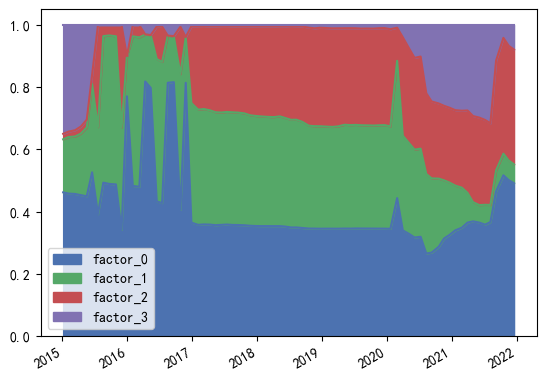

In [349]:
factor_risk_party_backtest_pca._strategy._factor_risk.div(factor_risk_party_backtest_pca._strategy._factor_risk.sum(1),axis = 0).abs().plot.area()

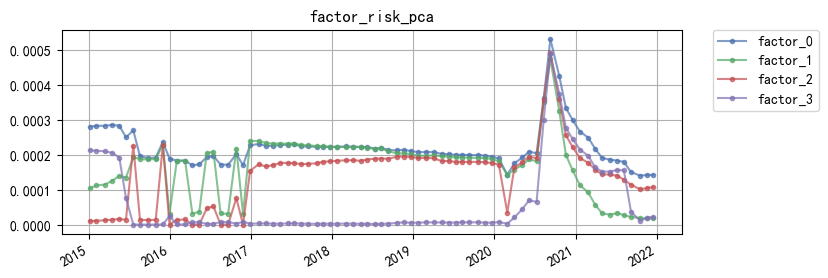

In [350]:
factor_risk_party_backtest_pca._strategy._factor_risk.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-', title='factor_risk_pca')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

<AxesSubplot:>

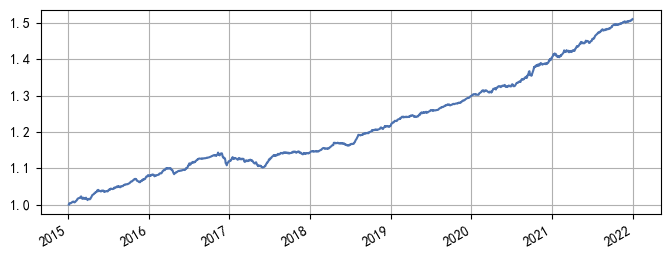

In [351]:
factor_risk_party_backtest_pca.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

In [357]:
factor_risk_party_backtest = BacktestManager(
        FactorRiskParityStrategy(factor_data=factor_data_raw), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = frequency, 
        look_back = look_back, 
    )
factor_risk_party_backtest.run()

  0%|▎                                                                                | 6/1705 [00:00<00:33, 51.31it/s]

False
[0.00000000e+00 0.00000000e+00 6.44568361e-02 9.35543164e-01
 9.78470585e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00]
2015-01-05 00:00:00
False
[0.         0.006914   0.2978008  0.62023909 0.07504611 0.
 0.         0.        ]
2015-02-04 00:00:00


  4%|███                                                                            | 67/1705 [00:00<00:15, 108.45it/s]

False
[0.00000000e+00 1.22137653e-02 3.01253112e-01 6.08030751e-01
 7.85023722e-02 0.00000000e+00 5.76683431e-16 0.00000000e+00]
2015-03-13 00:00:00
False
[3.25888479e-21 3.74393456e-03 2.68330728e-01 6.39721162e-01
 8.82041751e-02 4.37160995e-18 9.82560121e-21 1.51971151e-22]
2015-04-15 00:00:00


  7%|█████▏                                                                        | 113/1705 [00:00<00:13, 116.91it/s]

False
[2.49495418e-18 1.67821966e-02 1.63554813e-01 7.51681890e-01
 6.79810995e-02 6.60686235e-21 1.43805325e-20 2.08859191e-16]
2015-05-18 00:00:00
False
[1.84946919e-25 3.10070946e-16 1.00604416e-01 8.56826027e-01
 4.25695576e-02 2.14490057e-25 3.81022996e-25 3.32568754e-16]
2015-06-17 00:00:00


  8%|██████▍                                                                        | 138/1705 [00:01<00:15, 98.13it/s]

True
[4.74095761e-02 9.04060383e-18 7.49617941e-01 1.27550774e-02
 1.26496727e-01 3.28929713e-02 3.08277073e-02 2.50291374e-18]


  9%|███████▏                                                                       | 155/1705 [00:01<00:20, 76.86it/s]

True
[3.57927043e-02 1.62498480e-18 1.55800551e-01 7.74174580e-01
 1.25641295e-17 1.46801672e-02 1.82500396e-02 1.30195802e-03]


 12%|█████████▏                                                                     | 199/1705 [00:02<00:17, 83.91it/s]

True
[4.47229969e-02 0.00000000e+00 5.42353272e-01 2.82398618e-01
 1.10172158e-01 9.12460860e-22 2.03529551e-02 1.04799193e-16]
True
[2.49704120e-02 6.67860253e-03 1.37273490e-01 8.03158650e-01
 3.33557695e-16 1.22824538e-02 1.56363919e-02 2.88689979e-16]


 14%|███████████▎                                                                   | 243/1705 [00:02<00:15, 93.00it/s]

True
[2.85543886e-02 6.72777016e-18 1.33445219e-01 8.05763065e-01
 2.73392821e-18 1.60807862e-02 1.35723063e-02 2.58423548e-03]
True
[2.73732958e-02 8.05375555e-21 1.42748852e-01 7.97860761e-01
 9.03415278e-20 1.12584663e-02 1.75784771e-02 3.18014823e-03]


 17%|█████████████▏                                                                | 287/1705 [00:02<00:13, 101.52it/s]

True
[2.48411583e-02 1.17512552e-17 1.30350807e-01 8.16169198e-01
 3.73170851e-17 1.15955864e-02 1.70432496e-02 1.59583050e-16]
True
[4.56482995e-02 3.32037947e-16 6.83945199e-01 7.93181222e-02
 1.49873978e-01 1.16350247e-02 2.95793764e-02 8.26973011e-18]


 19%|███████████████▎                                                               | 331/1705 [00:03<00:17, 78.91it/s]

True
[6.70437304e-03 2.20816270e-02 1.42312340e-01 8.00659036e-01
 2.45222292e-16 1.91341331e-03 1.28233044e-02 1.35059062e-02]
True
[9.03617913e-21 2.89793657e-02 1.17377208e-01 7.99787521e-01
 4.15143161e-20 2.59513735e-02 2.52469236e-02 2.65760820e-03]


 21%|████████████████▎                                                              | 353/1705 [00:04<00:19, 71.08it/s]

True
[2.54067611e-17 2.64912019e-02 1.38067820e-01 7.69994313e-01
 1.25352873e-17 4.49649816e-02 2.04816838e-02 5.71839980e-17]


 22%|█████████████████▍                                                             | 375/1705 [00:04<00:17, 75.99it/s]

False
[1.34800586e-16 2.72238730e-02 1.44893267e-01 7.59890604e-01
 1.09189895e-17 5.34553529e-02 1.45369026e-02 2.13097701e-17]
2016-07-15 00:00:00


 25%|███████████████████▍                                                           | 419/1705 [00:04<00:15, 83.97it/s]

True
[7.66977366e-17 1.46665758e-02 1.98264291e-01 7.03632310e-01
 6.59068739e-19 4.33539824e-02 4.37150782e-03 3.57113334e-02]
True
[8.13367009e-17 9.97689491e-03 2.14327648e-01 6.86126673e-01
 8.17525838e-21 4.06936172e-02 9.38612082e-03 3.94890456e-02]


 27%|████████████████████▉                                                          | 453/1705 [00:05<00:15, 80.27it/s]

False
[1.57955348e-18 1.64916092e-02 1.48324511e-01 7.62387071e-01
 3.90762836e-19 2.76042389e-02 3.05914081e-02 1.46011611e-02]
2016-10-26 00:00:00


 27%|█████████████████████▍                                                         | 463/1705 [00:05<00:17, 70.41it/s]

True
[5.89162079e-17 1.93908832e-02 1.53738642e-01 7.53729837e-01
 2.20772847e-16 3.34136084e-02 3.91388495e-02 5.88179735e-04]
True
[2.71854010e-03 2.68249933e-02 1.41315621e-01 8.07945658e-01
 1.48865205e-16 4.26114729e-17 7.11402673e-17 2.11951871e-02]


 31%|████████████████████████▏                                                     | 529/1705 [00:05<00:11, 101.88it/s]

False
[5.18370950e-03 2.98078326e-02 1.10579139e-01 8.42202260e-01
 3.12921534e-19 6.81762635e-21 1.64279546e-16 1.22270589e-02]
2017-02-03 00:00:00
False
[0.00000000e+00 1.51823732e-15 3.84430304e-02 9.57514409e-01
 0.00000000e+00 5.30943142e-25 1.32104960e-16 4.04256106e-03]
2017-03-07 00:00:00


 33%|██████████████████████████                                                    | 571/1705 [00:06<00:09, 120.73it/s]

False
[0.00000000e+00 2.63065368e-16 8.01124957e-02 9.09596711e-01
 2.68948482e-21 2.59148337e-21 2.70606404e-16 1.02907928e-02]
2017-04-10 00:00:00


 34%|███████████████████████████                                                    | 585/1705 [00:06<00:11, 93.97it/s]

False
[2.05831676e-16 2.64247869e-02 1.05443776e-01 8.49202429e-01
 4.35505138e-19 2.33646261e-19 2.54740310e-18 1.89290087e-02]
2017-05-11 00:00:00
False
[2.03264144e-17 1.10266914e-15 5.94637831e-02 9.34585203e-01
 2.49156865e-17 4.11236746e-16 1.27845561e-16 5.95101344e-03]
2017-06-14 00:00:00


 37%|█████████████████████████████▏                                                | 639/1705 [00:07<00:10, 101.57it/s]

False
[1.76744321e-16 0.00000000e+00 1.09703340e-01 8.79653165e-01
 0.00000000e+00 4.41054341e-16 0.00000000e+00 1.06434948e-02]
2017-07-14 00:00:00
False
[6.17770187e-16 5.46395313e-16 8.85099925e-02 9.01711920e-01
 0.00000000e+00 0.00000000e+00 2.94360200e-18 9.77808699e-03]
2017-08-15 00:00:00


 39%|███████████████████████████████▏                                               | 672/1705 [00:07<00:12, 84.69it/s]

False
[9.30130241e-03 4.64464639e-03 1.79050023e-01 7.86865636e-01
 1.09015925e-16 1.74327474e-25 4.32990141e-16 2.01383922e-02]
2017-09-14 00:00:00


 41%|████████████████████████████████▌                                              | 704/1705 [00:07<00:10, 99.67it/s]

True
[6.78797110e-03 5.17053537e-03 1.66084907e-01 8.02517348e-01
 2.48059111e-16 4.70000821e-17 4.84001725e-17 1.94392390e-02]


 42%|█████████████████████████████████▏                                             | 717/1705 [00:08<00:11, 83.19it/s]

False
[1.26184226e-03 1.39397664e-02 1.53068972e-01 8.12206629e-01
 5.41869605e-22 1.32273655e-21 9.18231020e-22 1.95227907e-02]
2017-11-22 00:00:00


 43%|██████████████████████████████████▏                                            | 737/1705 [00:08<00:13, 72.85it/s]

False
[1.88284391e-15 2.61072402e-02 9.82860468e-02 8.61472747e-01
 2.05885990e-20 9.27533945e-21 6.61303867e-21 1.41339657e-02]
2017-12-22 00:00:00


 45%|███████████████████████████████████▎                                           | 762/1705 [00:08<00:14, 66.87it/s]

False
[2.78003481e-16 2.40677072e-02 1.12160180e-01 8.47872445e-01
 3.24842484e-21 1.43809532e-20 3.54063550e-16 1.58996675e-02]
2018-01-24 00:00:00


 46%|████████████████████████████████████▎                                          | 785/1705 [00:09<00:13, 67.69it/s]

False
[2.02156627e-15 2.50687923e-02 1.17406571e-01 8.43120456e-01
 3.38144923e-16 6.27302316e-17 3.35771462e-17 1.44041815e-02]
2018-03-02 00:00:00


 47%|█████████████████████████████████████▍                                         | 807/1705 [00:09<00:13, 66.07it/s]

False
[5.11569630e-04 2.96098581e-02 1.33738457e-01 8.23554011e-01
 2.08560176e-16 5.75425385e-17 2.37781841e-17 1.25861037e-02]
2018-04-03 00:00:00


 48%|█████████████████████████████████████▊                                         | 816/1705 [00:09<00:14, 60.73it/s]

False
[1.54577238e-02 3.61771765e-02 1.07975120e-01 8.40389979e-01
 8.48994424e-17 2.61968854e-18 1.01745102e-18 1.44639287e-17]
2018-05-09 00:00:00


 50%|███████████████████████████████████████▊                                       | 858/1705 [00:10<00:08, 97.44it/s]

False
[2.99836431e-02 1.67819858e-02 1.25837508e-01 8.27396863e-01
 5.24109504e-18 1.81204777e-18 2.23358710e-18 3.72697602e-18]
2018-06-08 00:00:00


 51%|████████████████████████████████████████▎                                      | 870/1705 [00:10<00:09, 90.54it/s]

False
[1.31667815e-02 4.28032214e-20 6.99186165e-01 8.39097973e-26
 2.36040885e-01 1.85480562e-21 1.62662096e-21 5.16061683e-02]
2018-07-11 00:00:00


 52%|████████████████████████████████████████▊                                      | 881/1705 [00:10<00:10, 79.45it/s]

False
[4.09477769e-02 5.99764742e-03 1.50342595e-01 8.02711981e-01
 1.47603759e-19 1.15886977e-22 1.10544230e-22 2.87982640e-22]
2018-08-10 00:00:00


 53%|█████████████████████████████████████████▊                                     | 903/1705 [00:10<00:09, 86.78it/s]

False
[3.45210987e-02 1.29636751e-02 1.37297601e-01 8.15217625e-01
 8.02466836e-17 2.00064997e-18 1.34155732e-20 4.58887291e-17]
2018-09-11 00:00:00


 54%|██████████████████████████████████████████▊                                    | 925/1705 [00:11<00:22, 35.11it/s]

False
[3.94564178e-02 5.96402890e-03 1.71680851e-01 7.82898702e-01
 1.29740836e-19 8.67408322e-19 5.06316968e-19 2.81010158e-19]
2018-10-19 00:00:00


 56%|███████████████████████████████████████████▉                                   | 947/1705 [00:12<00:21, 34.49it/s]

True
[4.05459102e-02 3.07517375e-03 1.71892856e-01 7.84486060e-01
 3.01414699e-16 2.03177189e-18 2.02272413e-16 1.07279713e-17]


 57%|████████████████████████████████████████████▉                                  | 969/1705 [00:12<00:17, 42.03it/s]

False
[3.03482573e-02 1.58179666e-02 2.19748912e-01 7.34084864e-01
 1.93494136e-16 3.77848215e-21 6.53243377e-17 2.36019187e-21]
2018-12-20 00:00:00


 59%|██████████████████████████████████████████████▎                               | 1013/1705 [00:13<00:10, 64.80it/s]

False
[2.79604011e-02 1.83107775e-02 2.41363459e-01 7.12365363e-01
 4.57143095e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00]
2019-01-23 00:00:00
False
[3.70650942e-02 5.05368532e-03 1.82850450e-01 7.75030771e-01
 2.46224615e-16 0.00000000e+00 4.25182251e-16 0.00000000e+00]
2019-03-01 00:00:00


 62%|████████████████████████████████████████████████▍                             | 1058/1705 [00:13<00:07, 81.29it/s]

False
[0.00000000e+00 4.39437078e-03 5.20424124e-02 9.43563217e-01
 2.16477515e-14 0.00000000e+00 0.00000000e+00 0.00000000e+00]
2019-04-02 00:00:00
False
[3.59776982e-02 5.22195149e-03 1.58322591e-01 8.00477759e-01
 1.09616953e-16 5.23365891e-16 4.36413400e-21 7.52369230e-21]
2019-05-08 00:00:00


 63%|█████████████████████████████████████████████████▎                            | 1079/1705 [00:13<00:06, 97.96it/s]

False
[3.34431837e-02 6.63665587e-03 1.49569741e-01 8.10350420e-01
 0.00000000e+00 2.04070296e-16 2.71431983e-15 3.41709117e-16]
2019-06-10 00:00:00


 66%|██████████████████████████████████████████████████▋                          | 1123/1705 [00:14<00:05, 106.62it/s]

False
[3.32140900e-02 7.89314081e-03 1.63307542e-01 7.95585228e-01
 1.35424997e-17 0.00000000e+00 2.39762498e-16 0.00000000e+00]
2019-07-10 00:00:00
False
[3.40395253e-02 8.06087653e-03 1.70779847e-01 7.87119751e-01
 4.48947248e-15 2.28823803e-20 4.36742155e-20 7.93238308e-20]
2019-08-09 00:00:00


 69%|█████████████████████████████████████████████████████▌                        | 1171/1705 [00:14<00:05, 93.09it/s]

False
[3.73334300e-02 5.81967870e-03 1.78175804e-01 7.78671087e-01
 3.66631673e-18 1.01077534e-16 1.25699695e-16 2.74265200e-16]
2019-09-10 00:00:00
False
[1.70755923e-15 4.54185831e-03 5.66842398e-02 9.38773902e-01
 4.65673703e-15 2.80774624e-22 2.17335137e-17 3.38594831e-17]
2019-10-18 00:00:00


 71%|███████████████████████████████████████████████████████▍                      | 1211/1705 [00:48<03:14,  2.55it/s]

False
[4.23311741e-02 3.82117676e-03 2.01497617e-01 7.51176961e-01
 1.17302405e-03 3.19941409e-22 4.77774223e-08 3.25843132e-22]
2019-11-19 00:00:00
True
[4.39144972e-02 4.15612056e-22 1.81608122e-01 7.74477380e-01
 1.23536032e-22 9.63836852e-18 1.11538064e-17 3.73333132e-22]


 73%|█████████████████████████████████████████████████████████▏                    | 1249/1705 [01:20<04:09,  1.83it/s]

False
[4.15226658e-02 3.52154444e-09 1.89748566e-01 7.67731137e-01
 8.01811422e-09 2.57113694e-04 8.19621539e-10 7.40504820e-04]
2020-01-21 00:00:00


 74%|█████████████████████████████████████████████████████████▍                    | 1255/1705 [01:55<08:58,  1.20s/it]

False
[1.98077829e-03 2.45959649e-02 1.99159066e-01 7.61758803e-01
 4.06577225e-03 1.31687003e-19 8.43961539e-03 2.88455835e-20]
2020-02-28 00:00:00


 76%|███████████████████████████████████████████████████████████▍                  | 1299/1705 [01:55<03:12,  2.11it/s]

True
[1.51731670e-02 1.75852681e-21 6.59754493e-01 1.91991687e-01
 4.44907278e-18 1.63520294e-20 1.31417067e-01 1.66358561e-03]
True
[6.96987454e-20 2.98387135e-02 2.58424108e-01 7.11737179e-01
 7.36970085e-17 1.69606635e-19 1.44900353e-16 2.03479858e-18]


 79%|█████████████████████████████████████████████████████████████▎                | 1339/1705 [02:31<03:47,  1.61it/s]

False
[5.60868142e-03 2.18344167e-02 2.41953429e-01 7.29446405e-01
 1.91503671e-21 1.15701949e-03 7.26713897e-22 4.77160996e-08]
2020-06-05 00:00:00
False
[5.71317921e-15 0.00000000e+00 4.86219398e-02 9.51378060e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
2020-07-09 00:00:00


 81%|███████████████████████████████████████████████████████████████▍              | 1387/1705 [02:32<01:16,  4.17it/s]

False
[8.99155133e-16 2.96830344e-02 2.74960820e-01 6.95356146e-01
 9.97677381e-21 1.48477277e-19 2.81733957e-22 1.07936512e-15]
2020-08-10 00:00:00
False
[2.76532375e-02 2.01374311e-15 1.37501677e-01 8.34845086e-01
 2.77414649e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00]
2020-09-09 00:00:00


 84%|█████████████████████████████████████████████████████████████████▍            | 1431/1705 [02:32<00:29,  9.30it/s]

False
[2.78108742e-02 1.17277520e-14 1.17599595e-01 8.54589530e-01
 6.05793711e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00]
2020-10-19 00:00:00
True
[3.07826707e-04 1.90003547e-26 6.44656722e-01 1.63443641e-01
 9.08816331e-02 3.58673279e-21 6.88248835e-02 3.18852944e-02]


 85%|██████████████████████████████████████████████████████████████████▍           | 1453/1705 [02:32<00:18, 13.34it/s]

False
[3.46314686e-02 2.32985511e-16 1.71783995e-01 7.93584537e-01
 2.13289599e-25 0.00000000e+00 2.77916744e-16 0.00000000e+00]
2020-12-18 00:00:00


 88%|████████████████████████████████████████████████████████████████████▎         | 1493/1705 [02:32<00:08, 24.04it/s]

True
[2.45981090e-03 4.14951412e-17 6.74428832e-01 1.37639089e-01
 9.23034072e-02 1.22898804e-17 6.97718313e-02 2.33970294e-02]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1517/1705 [03:15<01:44,  1.79it/s]

False
[2.53121966e-02 3.13443377e-03 1.64685407e-01 7.97604351e-01
 1.86912256e-05 5.98197078e-04 8.64672319e-03 2.09801712e-20]
2021-02-26 00:00:00


 89%|█████████████████████████████████████████████████████████████████████▍        | 1519/1705 [03:58<04:56,  1.59s/it]

False
[2.41982908e-02 6.25226462e-03 1.72346619e-01 7.87959884e-01
 1.38073244e-04 8.96124627e-05 9.01525638e-03 2.06219545e-20]
2021-03-30 00:00:00


 90%|██████████████████████████████████████████████████████████████████████▍       | 1541/1705 [04:29<04:08,  1.51s/it]

False
[2.18149373e-02 1.16037035e-02 1.88094894e-01 7.66766657e-01
 1.22259539e-20 4.01380127e-03 7.68208246e-03 2.39236957e-05]
2021-04-30 00:00:00


 92%|███████████████████████████████████████████████████████████████████████▌      | 1563/1705 [05:12<03:57,  1.67s/it]

False
[1.54608167e-02 1.59487904e-02 1.69852056e-01 7.84816422e-01
 3.62693602e-05 4.07799990e-03 9.41864207e-03 3.89003937e-04]
2021-06-04 00:00:00


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1602/1705 [05:12<01:20,  1.28it/s]

False
[6.22454714e-18 2.83413730e-02 2.37432478e-01 7.19674508e-01
 8.63006468e-03 1.01498669e-21 5.38824772e-03 5.33328136e-04]
2021-07-07 00:00:00


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1617/1705 [05:12<00:51,  1.72it/s]

False
[3.09341903e-02 2.44546161e-17 2.41922123e-01 7.21369234e-01
 9.53097715e-18 0.00000000e+00 5.77445220e-03 5.49883327e-17]
2021-08-06 00:00:00


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1650/1705 [05:13<00:15,  3.46it/s]

True
[2.71909740e-02 6.33658801e-04 2.20517123e-01 7.48878727e-01
 1.93463653e-16 2.18436179e-15 1.67175286e-16 2.77951791e-03]


 98%|████████████████████████████████████████████████████████████████████████████  | 1664/1705 [05:13<00:08,  4.59it/s]

False
[2.35036395e-02 1.23815776e-02 2.30801426e-01 7.33313357e-01
 2.98572443e-16 1.99717869e-19 3.24081965e-22 2.23634282e-16]
2021-10-18 00:00:00


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1690/1705 [05:13<00:01,  8.09it/s]

True
[3.34700696e-03 8.85098634e-17 4.03689573e-19 7.91649748e-01
 3.26764033e-18 1.30052495e-01 2.55869950e-02 4.93637550e-02]


100%|██████████████████████████████████████████████████████████████████████████████| 1705/1705 [05:13<00:00,  5.43it/s]

True
[5.62644399e-03 3.21902128e-21 8.77935640e-18 8.19718664e-01
 7.15497529e-22 1.00333915e-01 3.60617711e-02 3.82592063e-02]


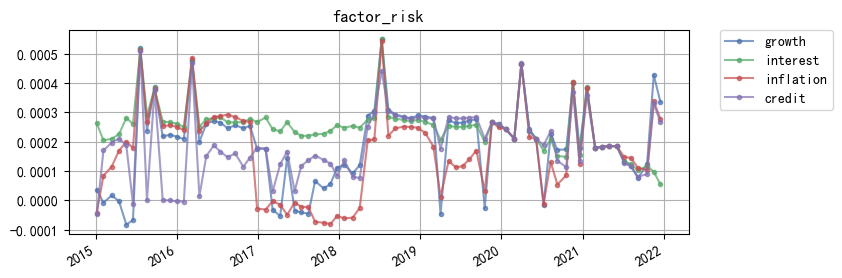

In [358]:
factor_risk_party_backtest._strategy._factor_risk.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-', title='factor_risk')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

<AxesSubplot:>

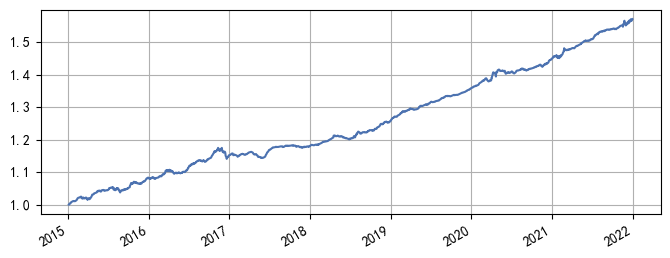

In [359]:
factor_risk_party_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

## 4. 等权重

In [360]:
class EqualWeightStrategy(Strategy):
    def run(self, id_date, asset_data): 
        return pd.Series([1/asset_data.shape[1]]*asset_data.shape[1], index=asset_data.columns)


In [361]:
equal_weight_backtest = BacktestManager(
        EqualWeightStrategy(), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = frequency, 
        look_back = look_back, 
    )
equal_weight_backtest.run()

100%|█████████████████████████████████████████████████████████████████████████████| 1705/1705 [00:08<00:00, 210.88it/s]


<AxesSubplot:>

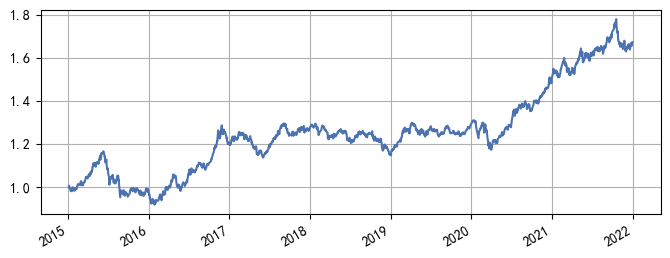

In [362]:
equal_weight_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

## 5. 资产风险平价和因子风险平价对比

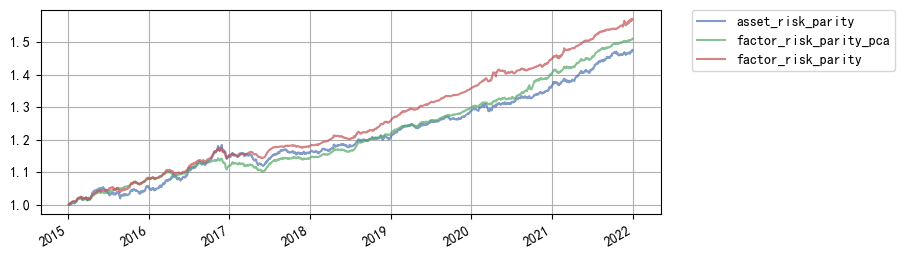

In [366]:
rp_values = pd.DataFrame({
    'asset_risk_parity': asset_risk_party_backtest.getHistoricalValue(scale=True), 
    'factor_risk_parity_pca': factor_risk_party_backtest_pca.getHistoricalValue(scale=True), 
    'factor_risk_parity': factor_risk_party_backtest.getHistoricalValue(scale=True), 
    #'equal_weight': equal_weight_backtest.getHistoricalValue(scale=True), 
})
rp_values.plot(figsize=(8,3), grid=True, alpha=0.7)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [365]:
# sharpe
sharpe = ((rp_values.iloc[-1]/rp_values.iloc[0]) ** (252/rp_values.shape[0]) - 1 - 0.035) / (rp_values.pct_change().std() * 252**0.5)
sharpe


asset_risk_parity         0.908917
factor_risk_parity_pca    1.731552
factor_risk_parity        1.957975
equal_weight              0.421205
dtype: float64